# Gráficos de Barras: Congruencia vs Incongruencia Ideológica

Este notebook genera **gráficos de barras** para comparar las medias de Cambio de Opinión (CO) y Cambio de Tiempo (CT) según congruencia ideológica.

## Objetivo:

Visualizar y comparar las medias de congruencia/incongruencia con barras de error, permitiendo identificar:
- Diferencias entre medias
- Variabilidad (error estándar)
- Significancia estadística

## Variables analizadas:

- **CO_Congruente**: Ítems Progresistas → Izquierda + Ítems Conservadores → Derecha
- **CO_Incongruente**: Ítems Progresistas → Derecha + Ítems Conservadores → Izquierda
- **CT_Congruente**: Tiempos en dirección ideológicamente consistente
- **CT_Incongruente**: Tiempos en dirección ideológicamente inconsistente

## Elecciones:

- Generales
- Ballotage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook', font_scale=1.1)

print('✓ Librerías cargadas exitosamente')

✓ Librerías cargadas exitosamente


## 1. Cargar Datos

In [2]:
# Rutas a los archivos
Ruta_Base = os.path.join(os.getcwd(), '..', 'Data', 'Procesados')
Archivo_Generales = os.path.join(Ruta_Base, 'Generales_con_Congruencia.xlsx')
Archivo_Ballotage = os.path.join(Ruta_Base, 'Ballotage_con_Congruencia.xlsx')

# Cargar datos
df_Generales = pd.read_excel(Archivo_Generales)
df_Ballotage = pd.read_excel(Archivo_Ballotage)

print(f'✓ Datos cargados:')
print(f'  - Generales: {len(df_Generales)} registros')
print(f'  - Ballotage: {len(df_Ballotage)} registros')

# Verificar variables
vars_necesarias = ['CO_Congruente', 'CO_Incongruente', 'CT_Congruente', 'CT_Incongruente']

for nombre, df in [('Generales', df_Generales), ('Ballotage', df_Ballotage)]:
    faltantes = [v for v in vars_necesarias if v not in df.columns]
    if faltantes:
        print(f'  ⚠️  {nombre}: Faltan variables {faltantes}')
    else:
        print(f'  ✓ {nombre}: Todas las variables presentes')

✓ Datos cargados:
  - Generales: 2786 registros
  - Ballotage: 1254 registros
  ✓ Generales: Todas las variables presentes
  ✓ Ballotage: Todas las variables presentes


## 2. Función de Visualización

In [3]:
def Crear_Grafico_Barras(df, variable_nombre, eleccion_nombre, guardar=True):
    """
    Crea gráfico de barras para una variable específica con error estándar.
    
    Parámetros:
    -----------
    df : DataFrame con datos
    variable_nombre : 'Cambio de Opinión' o 'Cambio de Tiempo'
    eleccion_nombre : 'Generales' o 'Ballotage'
    guardar : bool, si True guarda el gráfico
    """
    
    # Determinar variables
    if variable_nombre == 'Cambio de Opinión':
        var_cong = 'CO_Congruente'
        var_incong = 'CO_Incongruente'
        tipo_corto = 'CO'
    else:
        var_cong = 'CT_Congruente'
        var_incong = 'CT_Incongruente'
        tipo_corto = 'CT'
    
    # Calcular estadísticas
    datos_cong = df[var_cong].dropna()
    datos_incong = df[var_incong].dropna()
    
    medias = [datos_cong.mean(), datos_incong.mean()]
    errores = [datos_cong.sem(), datos_incong.sem()]  # Error estándar
    
    # Test de significancia
    datos_pareados = df[[var_cong, var_incong]].dropna()
    if len(datos_pareados) > 0:
        stat, p_valor = stats.wilcoxon(datos_pareados[var_cong], 
                                        datos_pareados[var_incong])
        
        if p_valor < 0.001:
            sig = '***'
        elif p_valor < 0.01:
            sig = '**'
        elif p_valor < 0.05:
            sig = '*'
        else:
            sig = 'ns'
    else:
        sig = 'ns'
        p_valor = 1.0
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Colores: Verde menta y Lavanda
    colores = ['#8dd3c7', '#bebada']
    
    # Posiciones de las barras
    x_pos = np.arange(2)
    
    # Crear barras
    barras = ax.bar(x_pos, medias, yerr=errores, 
                     color=colores, 
                     alpha=0.85,
                     edgecolor='black',
                     linewidth=2,
                     capsize=10,
                     error_kw={'linewidth': 2, 'elinewidth': 2, 'capthick': 2})
    
    # Configurar fondo con grid sutil
    ax.set_facecolor('#fafafa')
    ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray', axis='y')
    ax.set_axisbelow(True)
    
    # Configurar ejes
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Congruente', 'Incongruente'], 
                        fontsize=14, fontweight='bold')
    ax.set_ylabel('Media', fontsize=14, fontweight='bold')
    ax.tick_params(axis='y', labelsize=12)
    
    # Título
    ax.set_title(f'{variable_nombre}: Congruente vs Incongruente\n{eleccion_nombre}',
                 fontsize=16, fontweight='bold', pad=20)
    
    # Añadir línea en cero
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.6, zorder=0)
    
    # Añadir valores sobre las barras
    for i, (media, error) in enumerate(zip(medias, errores)):
        altura = media + error + (0.02 * (max(medias) - min(medias)))
        ax.text(i, altura, f'{media:.3f}', 
                ha='center', va='bottom', 
                fontsize=12, fontweight='bold')
    
    # Añadir significancia estadística
    if sig != 'ns':
        # Línea conectando las barras
        y_max = max([m + e for m, e in zip(medias, errores)])
        y_sig = y_max + 0.05 * (max(medias) - min(medias))
        
        ax.plot([0, 1], [y_sig, y_sig], 'k-', linewidth=1.5)
        ax.plot([0, 0], [y_sig - 0.01, y_sig], 'k-', linewidth=1.5)
        ax.plot([1, 1], [y_sig - 0.01, y_sig], 'k-', linewidth=1.5)
        
        # Texto de significancia
        ax.text(0.5, y_sig + 0.02, sig, 
                ha='center', va='bottom', 
                fontsize=14, fontweight='bold')
    
    # Añadir texto con p-valor
    ax.text(0.02, 0.98, f'p = {p_valor:.4f}', 
            transform=ax.transAxes,
            fontsize=11, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Crear leyenda fuera del gráfico
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    legend_elements = [
        Patch(facecolor='#8dd3c7', edgecolor='black', linewidth=2, 
              label='Congruente', alpha=0.85),
        Patch(facecolor='#bebada', edgecolor='black', linewidth=2, 
              label='Incongruente', alpha=0.85),
        Line2D([0], [0], color='black', linewidth=2, marker='_', 
               markersize=15, label='Media ± Error Estándar'),
        Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, 
               label='Línea de cero', alpha=0.6)
    ]
    
    # Posicionar leyenda fuera del área de ploteo
    ax.legend(handles=legend_elements, 
              loc='upper left', 
              bbox_to_anchor=(1.02, 1),
              fontsize=11,
              frameon=True,
              fancybox=True,
              shadow=True,
              framealpha=0.95)
    
    # Ajustar layout para que la leyenda no se corte
    plt.tight_layout()
    
    # Guardar como SVG
    if guardar:
        carpeta = 'Graficos_Barras'
        if not os.path.exists(carpeta):
            os.makedirs(carpeta)
        
        nombre_archivo = f'Barras_{tipo_corto}_{eleccion_nombre}.svg'
        ruta = os.path.join(carpeta, nombre_archivo)
        plt.savefig(ruta, format='svg', bbox_inches='tight', facecolor='white')
        print(f'✓ Gráfico guardado: {ruta}')
    
    plt.show()
    
    return fig, ax, {'media_cong': medias[0], 'media_incong': medias[1], 
                     'p_valor': p_valor, 'significancia': sig}

## 3. Estadísticas Descriptivas

In [4]:
print('='*70)
print('ESTADÍSTICAS DESCRIPTIVAS')
print('='*70)

resultados_estadisticos = []

for nombre, df in [('Generales', df_Generales), ('Ballotage', df_Ballotage)]:
    print(f'\n📊 {nombre}:')
    print('-'*70)
    
    for var_nombre, var_cong, var_incong in [
        ('CO', 'CO_Congruente', 'CO_Incongruente'),
        ('CT', 'CT_Congruente', 'CT_Incongruente')
    ]:
        datos_cong = df[var_cong].dropna()
        datos_incong = df[var_incong].dropna()
        
        print(f'\n  {var_nombre}:')
        print(f'    Congruente:')
        print(f'      n      = {len(datos_cong)}')
        print(f'      Media  = {datos_cong.mean():.4f}')
        print(f'      DE     = {datos_cong.std():.4f}')
        print(f'      EE     = {datos_cong.sem():.4f}')
        print(f'      Min    = {datos_cong.min():.4f}')
        print(f'      Max    = {datos_cong.max():.4f}')
        
        print(f'\n    Incongruente:')
        print(f'      n      = {len(datos_incong)}')
        print(f'      Media  = {datos_incong.mean():.4f}')
        print(f'      DE     = {datos_incong.std():.4f}')
        print(f'      EE     = {datos_incong.sem():.4f}')
        print(f'      Min    = {datos_incong.min():.4f}')
        print(f'      Max    = {datos_incong.max():.4f}')
        
        resultados_estadisticos.append({
            'Eleccion': nombre,
            'Variable': var_nombre,
            'Media_Congruente': datos_cong.mean(),
            'EE_Congruente': datos_cong.sem(),
            'Media_Incongruente': datos_incong.mean(),
            'EE_Incongruente': datos_incong.sem(),
            'n_Congruente': len(datos_cong),
            'n_Incongruente': len(datos_incong)
        })

print('\n' + '='*70)

ESTADÍSTICAS DESCRIPTIVAS

📊 Generales:
----------------------------------------------------------------------

  CO:
    Congruente:
      n      = 2786
      Media  = 0.7968
      DE     = 3.6455
      EE     = 0.0691
      Min    = -17.0000
      Max    = 19.0000

    Incongruente:
      n      = 2786
      Media  = -0.7175
      DE     = 3.4926
      EE     = 0.0662
      Min    = -18.0000
      Max    = 17.0000

  CT:
    Congruente:
      n      = 2786
      Media  = -20.1842
      DE     = 53.7236
      EE     = 1.0178
      Min    = -1268.4400
      Max    = 511.7080

    Incongruente:
      n      = 2786
      Media  = -18.7598
      DE     = 51.2612
      EE     = 0.9712
      Min    = -1275.3110
      Max    = 495.8130

📊 Ballotage:
----------------------------------------------------------------------

  CO:
    Congruente:
      n      = 1254
      Media  = 0.3373
      DE     = 3.3643
      EE     = 0.0950
      Min    = -13.0000
      Max    = 18.0000

    Incongruente:


## 4. Gráficos de Barras

### 4.1. Gráficos: Generales

Generando gráficos para Generales...

✓ Gráfico guardado: Graficos_Barras\Barras_CO_Generales.svg


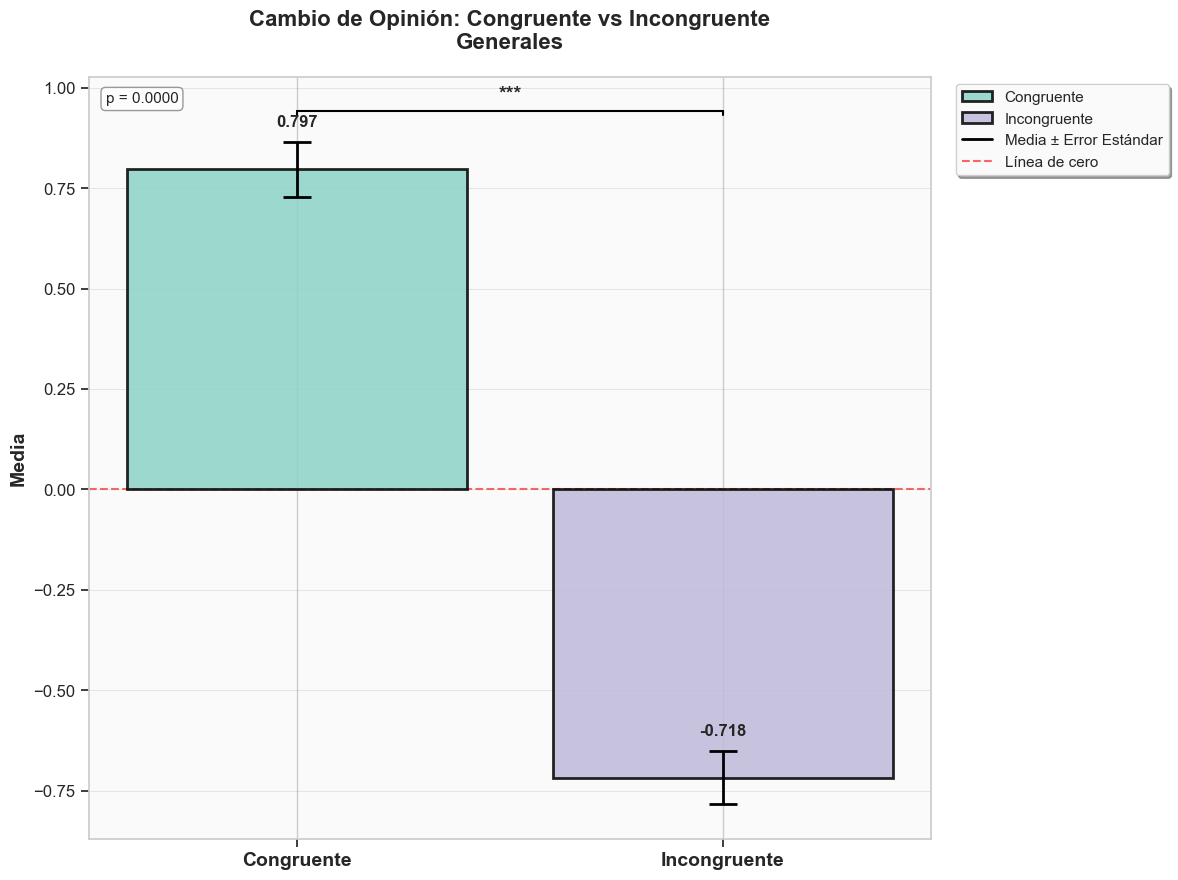

In [5]:
print('Generando gráficos para Generales...\n')

# CO Generales
fig_co_gen, ax_co_gen, stats_co_gen = Crear_Grafico_Barras(
    df_Generales,
    'Cambio de Opinión',
    'Generales'
)

✓ Gráfico guardado: Graficos_Barras\Barras_CT_Generales.svg


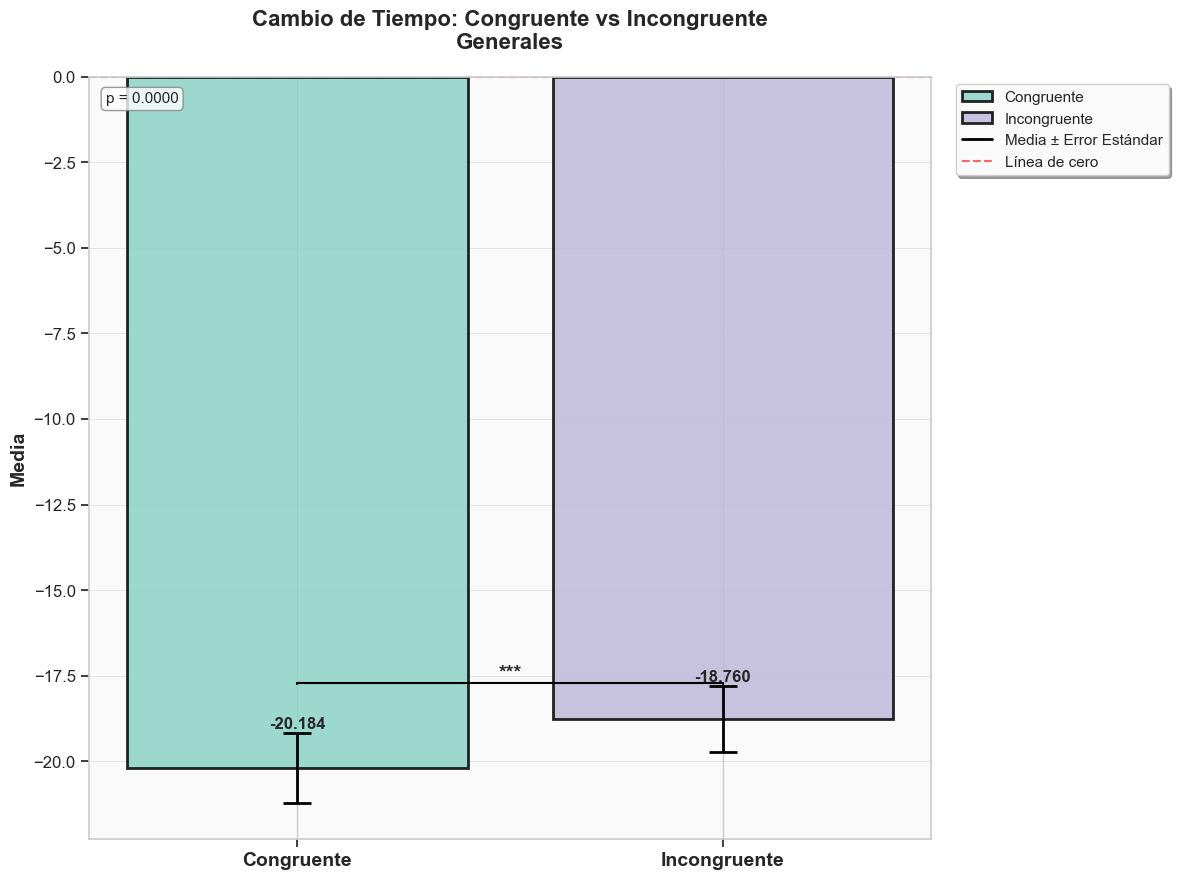

In [6]:
# CT Generales
fig_ct_gen, ax_ct_gen, stats_ct_gen = Crear_Grafico_Barras(
    df_Generales,
    'Cambio de Tiempo',
    'Generales'
)

### 4.2. Gráficos: Ballotage

Generando gráficos para Ballotage...

✓ Gráfico guardado: Graficos_Barras\Barras_CO_Ballotage.svg


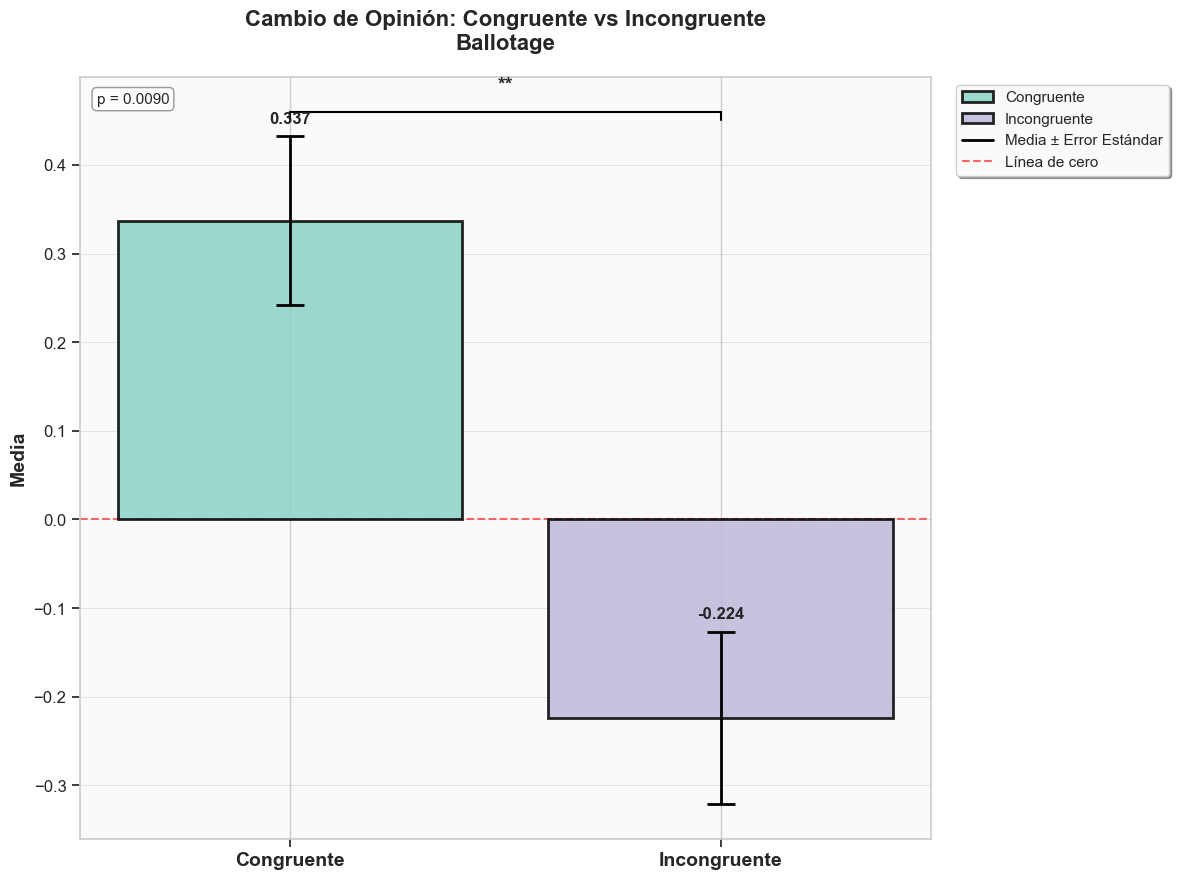

In [7]:
print('Generando gráficos para Ballotage...\n')

# CO Ballotage
fig_co_bal, ax_co_bal, stats_co_bal = Crear_Grafico_Barras(
    df_Ballotage,
    'Cambio de Opinión',
    'Ballotage'
)

✓ Gráfico guardado: Graficos_Barras\Barras_CT_Ballotage.svg


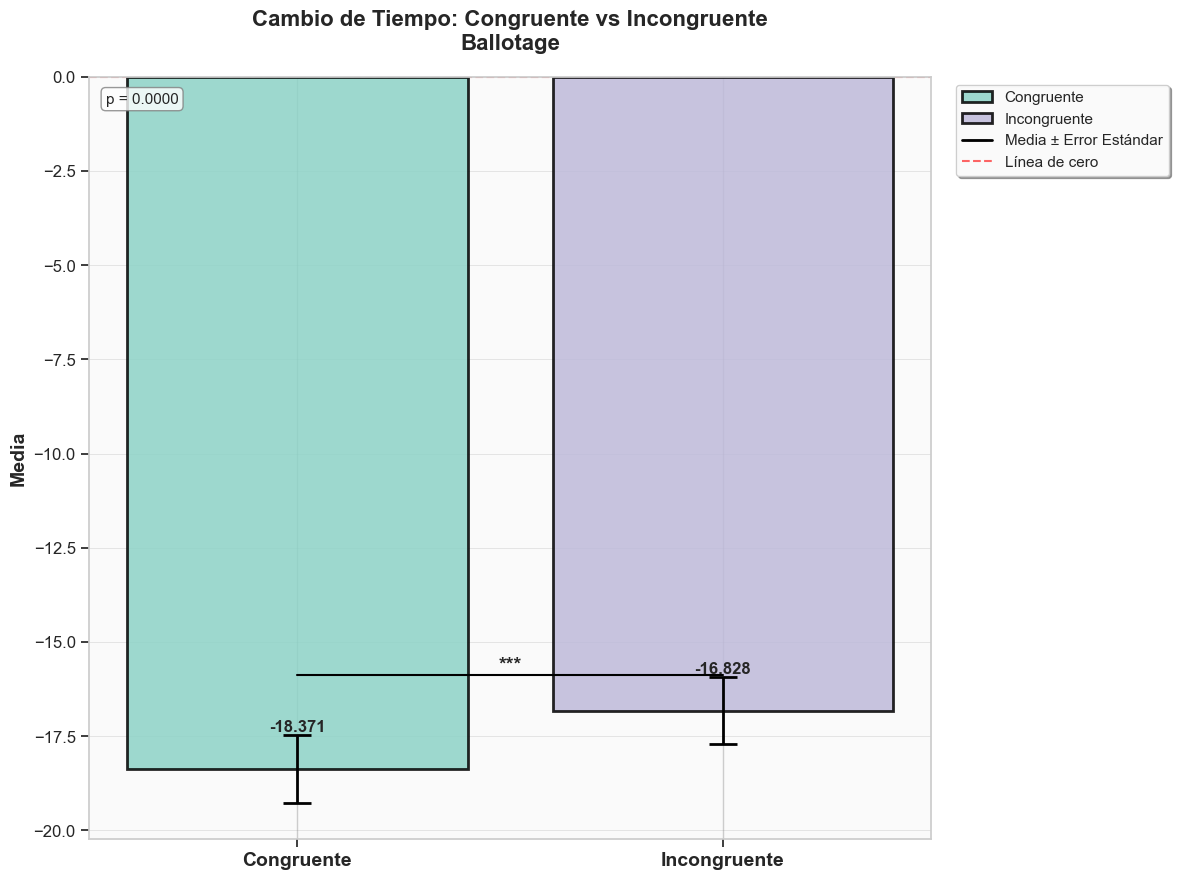

In [8]:
# CT Ballotage
fig_ct_bal, ax_ct_bal, stats_ct_bal = Crear_Grafico_Barras(
    df_Ballotage,
    'Cambio de Tiempo',
    'Ballotage'
)

## 5. Tabla Resumen de Resultados

In [9]:
# Compilar todos los resultados
todos_resultados = [
    {'Eleccion': 'Generales', 'Variable': 'CO', **stats_co_gen},
    {'Eleccion': 'Generales', 'Variable': 'CT', **stats_ct_gen},
    {'Eleccion': 'Ballotage', 'Variable': 'CO', **stats_co_bal},
    {'Eleccion': 'Ballotage', 'Variable': 'CT', **stats_ct_bal}
]

df_resultados = pd.DataFrame(todos_resultados)

print('='*70)
print('RESUMEN DE RESULTADOS')
print('='*70)
print('\n', df_resultados.to_string(index=False))
print('\n' + '='*70)

RESUMEN DE RESULTADOS

  Eleccion Variable  media_cong  media_incong      p_valor significancia
Generales       CO    0.796841     -0.717516 3.110308e-41           ***
Generales       CT  -20.184184    -18.759792 2.095496e-18           ***
Ballotage       CO    0.337321     -0.224083 9.005261e-03            **
Ballotage       CT  -18.371365    -16.828364 5.818371e-06           ***



## 6. Guardar Resultados

In [10]:
# Guardar tabla de resultados
Carpeta_Salida = os.path.join(os.getcwd(), '..', 'Data', 'Resultados_Barras')
if not os.path.exists(Carpeta_Salida):
    os.makedirs(Carpeta_Salida)

archivo = os.path.join(Carpeta_Salida, 'Resultados_Barras_Congruencia.xlsx')
df_resultados.to_excel(archivo, index=False)
print(f'✓ Resultados guardados: {archivo}')

✓ Resultados guardados: c:\Users\Patricio\Documents\Codigo\Python\Investigacion\Tesis\Código\..\Data\Resultados_Barras\Resultados_Barras_Congruencia.xlsx


## 7. Resumen Final

In [11]:
print('='*70)
print('RESUMEN: GRÁFICOS DE BARRAS - CONGRUENCIA IDEOLÓGICA')
print('='*70)

print('\n📊 Análisis completado:')
print('  - Gráficos generados: 4 (2 por elección)')
print('  - Variables analizadas: CO y CT (Congruente vs Incongruente)')
print('  - Elecciones: Generales y Ballotage')
print('  - Test estadístico: Wilcoxon pareado')

print('\n📁 Archivos generados:')
print('  Gráficos:')
print('    - Graficos_Barras/Barras_CO_Generales.svg')
print('    - Graficos_Barras/Barras_CT_Generales.svg')
print('    - Graficos_Barras/Barras_CO_Ballotage.svg')
print('    - Graficos_Barras/Barras_CT_Ballotage.svg')
print('  Datos:')
print('    - Data/Resultados_Barras/Resultados_Barras_Congruencia.xlsx')

print('\n💡 Interpretación de gráficos de barras:')
print('  - Altura de barra: media del grupo')
print('  - Barras de error: error estándar de la media')
print('  - Asteriscos: significancia estadística')
print('    * p < 0.05')
print('    ** p < 0.01')
print('    *** p < 0.001')
print('    ns = no significativo')

print('\n🎯 Hallazgos principales:')

for _, row in df_resultados.iterrows():
    if row['significancia'] != 'ns':
        direccion = 'Congruente > Incongruente' if row['media_cong'] > row['media_incong'] else 'Incongruente > Congruente'
        print(f"  {row['Eleccion']} - {row['Variable']}: {direccion} (p = {row['p_valor']:.4f} {row['significancia']})")

print('\n' + '='*70)
print('✓ ANÁLISIS COMPLETADO')
print('='*70)

RESUMEN: GRÁFICOS DE BARRAS - CONGRUENCIA IDEOLÓGICA

📊 Análisis completado:
  - Gráficos generados: 4 (2 por elección)
  - Variables analizadas: CO y CT (Congruente vs Incongruente)
  - Elecciones: Generales y Ballotage
  - Test estadístico: Wilcoxon pareado

📁 Archivos generados:
  Gráficos:
    - Graficos_Barras/Barras_CO_Generales.svg
    - Graficos_Barras/Barras_CT_Generales.svg
    - Graficos_Barras/Barras_CO_Ballotage.svg
    - Graficos_Barras/Barras_CT_Ballotage.svg
  Datos:
    - Data/Resultados_Barras/Resultados_Barras_Congruencia.xlsx

💡 Interpretación de gráficos de barras:
  - Altura de barra: media del grupo
  - Barras de error: error estándar de la media
  - Asteriscos: significancia estadística
    * p < 0.05
    ** p < 0.01
    *** p < 0.001
    ns = no significativo

🎯 Hallazgos principales:
  Generales - CO: Congruente > Incongruente (p = 0.0000 ***)
  Generales - CT: Incongruente > Congruente (p = 0.0000 ***)
  Ballotage - CO: Congruente > Incongruente (p = 0.0090 *